### 비트코인 차트데이터
- https://blog.naver.com/moongda0404/222729530178
- 

#### 1. 데이터 및 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [43]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = 'market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df

,day,price
0,2021-10-07 00:00:00,55343.76
1,2021-10-08 00:00:00,53801.10
2,2021-10-09 00:00:00,53867.30
3,2021-10-10 00:00:00,55122.59
4,2021-10-11 00:00:00,54625.74
...,...,...
360,2022-10-02 00:00:00,19314.69
361,2022-10-03 00:00:00,19049.72
362,2022-10-04 00:00:00,19632.61
363,2022-10-05 00:00:00,20342.25


- x축은 'day'이고, y축은 'price'
    - day는 단위가 '하루'이기에, 시계열 피처단위로 바꾼다

In [44]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df

,day,price
0,2021-10-07,55343.76
1,2021-10-08,53801.10
2,2021-10-09,53867.30
3,2021-10-10,55122.59
4,2021-10-11,54625.74
...,...,...
360,2022-10-02,19314.69
361,2022-10-03,19049.72
362,2022-10-04,19632.61
363,2022-10-05,20342.25


- day를 index로 지정

In [45]:
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

In [46]:
bitcoin_df

,price
day,
2021-10-07,55343.76
2021-10-08,53801.10
2021-10-09,53867.30
2021-10-10,55122.59
2021-10-11,54625.74
...,...
2022-10-02,19314.69
2022-10-03,19049.72
2022-10-04,19632.61


#### 2. 시각화

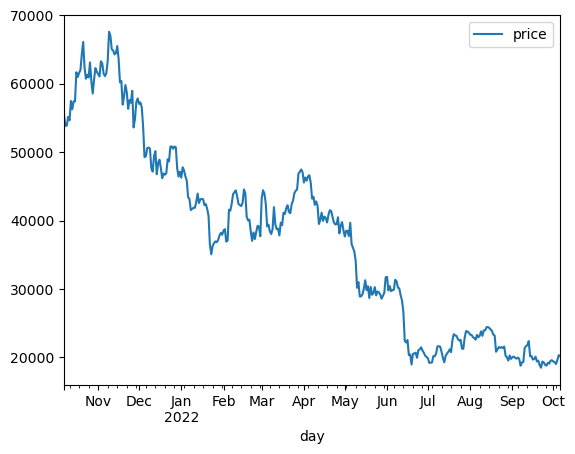

In [47]:
bitcoin_df.plot()
plt.show()

#### 3. 예측 모델
- ARIMA를 활용
    - ARIMA(Autoregressvie integrated MovingAverage)
        - AR(자기상관) : 이전의 값이 이후의 값에 영향을 미치고 있는 상황
        - MA(이동평균) : 랜덤 변수의 평균값이 지속적으로 증가하거나 감소하는 추세
            - 차분은 비정상성을 정상성으로 만들기 위해, 관측값들의 차이를 계산하는 것 (비정상성에서 정상성으로)

In [49]:
bitcoin_df_train = bitcoin_df[:360]

In [50]:
bitcoin_df_train

,price
day,
2021-10-07,55343.76
2021-10-08,53801.10
2021-10-09,53867.30
2021-10-10,55122.59
2021-10-11,54625.74
...,...
2022-09-27,19227.26
2022-09-28,19104.89
2022-09-29,19530.71


In [51]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA   

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df_train.price.values, order=(2,1,2))

In [52]:
#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3083.359
Date:                Fri, 07 Oct 2022   AIC                           6176.719
Time:                        10:42:30   BIC                           6196.135
Sample:                             0   HQIC                          6184.440
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5403      0.012     44.230      0.000       0.516       0.564
ar.L2         -0.9696      0.012    -79.333      0.000      -0.994      -0.946
ma.L1         -0.5758      0.021    -27.387      0.0

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- ARIMA 모델 학습에 의한 예측결과

In [75]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

In [76]:
forecast_data

array([19367.23687231, 19376.65073743, 19439.87568695, 19464.90586576,
       19417.12692905])

In [77]:
bitcoin_test_df = pd.read_csv(file_path, names=['ds', 'y'])

In [78]:
bitcoin_test_df = bitcoin_test_df[360:]

In [84]:
pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.

In [85]:
pred_y

19367.236872307934

In [86]:
test_y

array([['2022-10-02 00:00:00', 19314.69],
       ['2022-10-03 00:00:00', 19049.72],
       ['2022-10-04 00:00:00', 19632.61],
       ['2022-10-05 00:00:00', 20342.25],
       ['2022-10-06 00:00:00', 20167.79]], dtype=object)

In [87]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
    
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

TypeError: 'numpy.float64' object is not iterable

#### 4. fbprophet 예측 모델

In [88]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

Initial log joint probability = -3.17687
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1162.2    0.00576462       65.6941       0.991       0.991      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1163.81    0.00116402       92.4007       0.909       0.909      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1172.45     0.0424507        1007.1      0.6408           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1189.21     0.0129823         358.8           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1196.47    0.00199243       487.755      0.4665      0.4665      599   
    Iter      log prob        ||dx||      ||grad||       alpha  

  1224.81    0.00331567       394.337           1           1      713   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1236.71    0.00152192       153.968           1           1      835   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1239.08    0.00235162       280.234      0.9695      0.9695      959   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1245.27     0.0149065       2015.44           1           1     1071   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1248.59    0.00412387       1510.43           1           1     1183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1250.67   0.000255287       231.469           1           1     1300   
    Iter      log prob        |

In [89]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2022-10-07,19967.642918,18479.829002,21454.470102
366,2022-10-08,20159.698370,18716.857329,21703.841952
367,2022-10-09,20530.715424,18967.800439,22088.945988
368,2022-10-10,20954.023833,19325.773838,22585.773599
369,2022-10-11,21402.502760,19647.761121,23232.438374


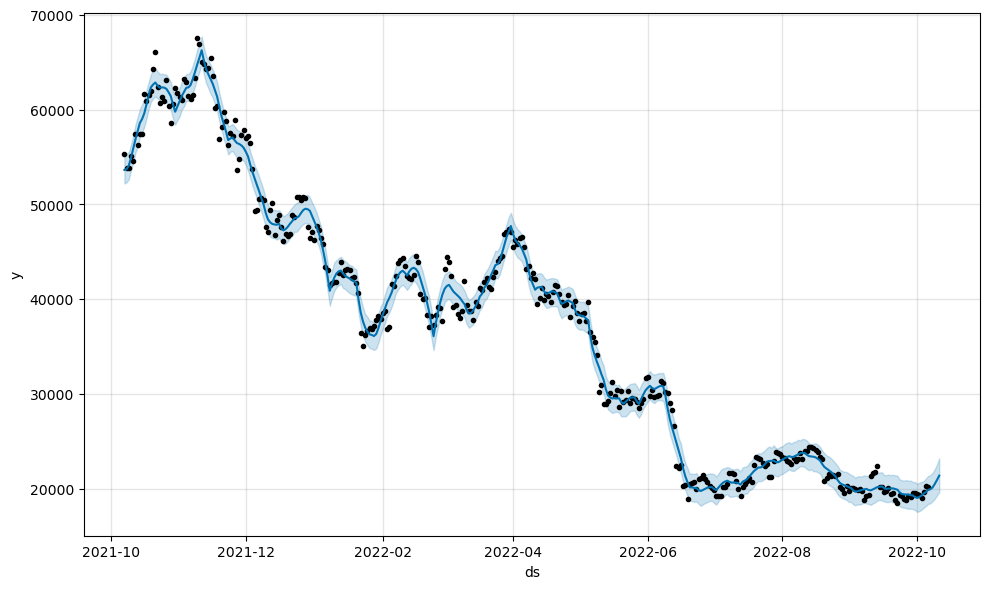

In [90]:
fig1 = prophet.plot(forecast_data)

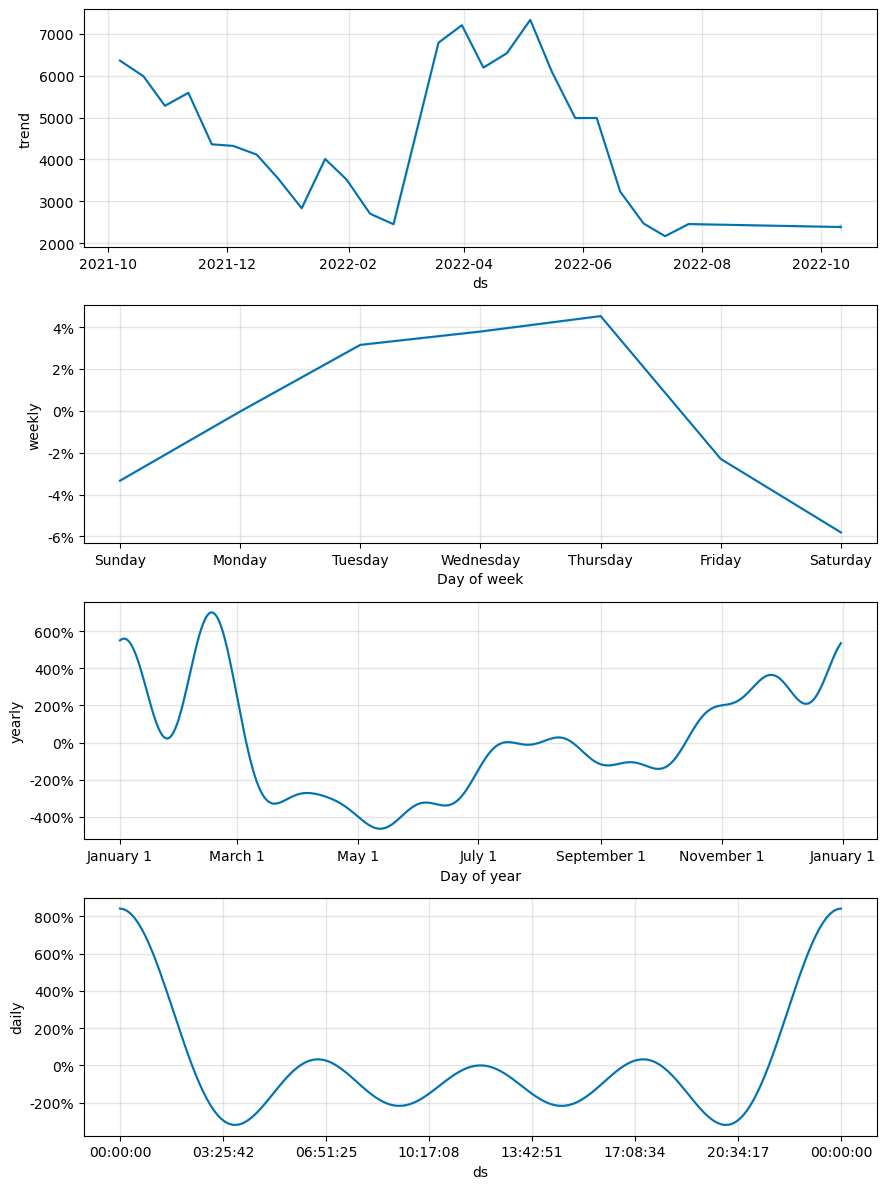

In [91]:
fig2 = prophet.plot_components(forecast_data)

In [106]:
bitcoin_df_train = bitcoin_df[:360]
bitcoin_test_df = bitcoin_df[360:]

In [107]:
bitcoin_test_df

,ds,y
360,2022-10-02 00:00:00,19314.69
361,2022-10-03 00:00:00,19049.72
362,2022-10-04 00:00:00,19632.61
363,2022-10-05 00:00:00,20342.25
364,2022-10-06 00:00:00,20167.79


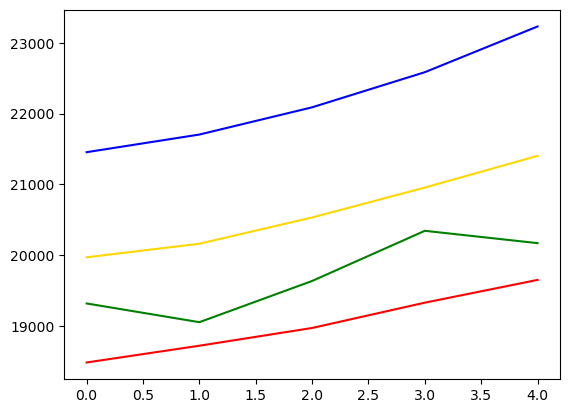

In [109]:
pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [110]:
pred_y

array([19967.64291802, 20159.69837007, 20530.71542435, 20954.02383289,
       21402.50275979])

In [111]:
test_y

array([19314.69, 19049.72, 19632.61, 20342.25, 20167.79])

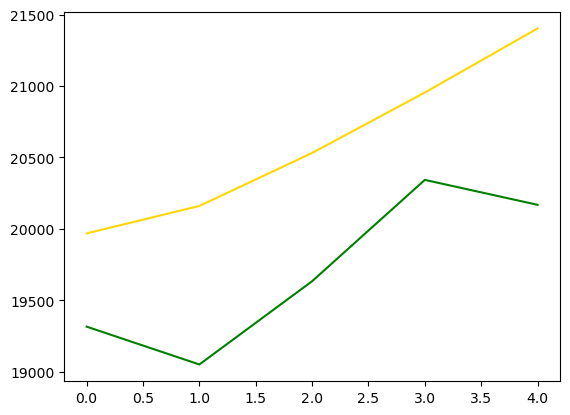

In [112]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.